## Objective:

Perform an correspondence analysis for PISA data to see how the features relate to each other, and weather or not belonging to OCDE can associate to scholar performance. For the numerical variables we will first perform a  Principal Component Analysis (PCA) and then categorize the resulting factors from PCA as a categorical variable and perform an correspondence analysis with the categorical OECD/non-OCDE ocuntry variable

In [79]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bartlett

from factor_analyzer import FactorAnalyzer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
from scipy.stats import chi2_contingency

import statsmodels.api as sm
import plotly.graph_objects as go

In [20]:
df = pd.read_csv('../data/notas_pisa.csv', delimiter=',')
df.head()
df.drop(columns=['mathematics_2018', 'reading_2018', 'science_2018', 'country'], inplace=True)
numerics_columns = ['mathematics_2022', 'reading_2022', 'science_2022']
categorical_vars = ['group']
df[numerics_columns] = df[numerics_columns].apply(pd.to_numeric, errors='coerce')
df[categorical_vars] = df[categorical_vars].astype('category')
df.dropna(inplace=True)
df.reset_index(inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 81 entries, 0 to 80
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   index             81 non-null     int64   
 1   group             81 non-null     category
 2   mathematics_2022  81 non-null     float64 
 3   reading_2022      81 non-null     float64 
 4   science_2022      81 non-null     float64 
dtypes: category(1), float64(3), int64(1)
memory usage: 2.9 KB


In [21]:
df.head()

,index,group,mathematics_2022,reading_2022,science_2022
0,0,OECD,487.084254,498.050940,507.000869
1,1,OECD,487.267499,480.405847,491.270959
2,2,OECD,489.486817,478.852668,490.578346
3,3,OECD,496.947894,507.132896,515.016676
4,4,OECD,411.696571,447.978957,443.543402


In [40]:
df_PCA = df[numerics_columns]
df_correspondence = df[categorical_vars]

correl_df = df_PCA.corr()

Text(0.5, 1.0, 'Correlation Heatmap')

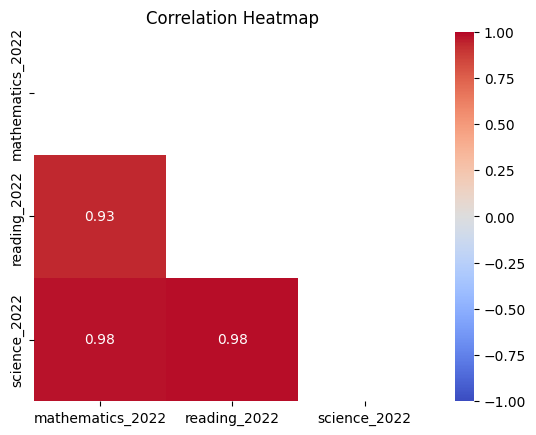

In [23]:
mask = np.triu(np.ones_like(correl_df, dtype=bool))

plt.figure()
sns.heatmap(correl_df, annot=True, fmt='.2f', mask=mask, cmap='coolwarm', vmin=-1.0, vmax=1.0)
plt.title('Correlation Heatmap')

Variables are highly correlated, indicating it is probably interesting to use a PCA analysis 

In [24]:
data_columns = [df_PCA[col] for col in df_PCA.columns]

In [25]:
bartlett_stat, p_value = calculate_bartlett_sphericity(df_PCA)
print(f'Qui² Bartlett: {round(bartlett_stat, 2)}')
print(f'p-valor: {round(p_value, 4)}')

# p-value bellow 0.05 indicates that variables in the dataframe intercorrelate, and thus it makes sense to create a fator to represent them.

Qui² Bartlett: 508.46
p-valor: 0.0


In [26]:
PCA = FactorAnalyzer(n_factors=3, method='principal', rotation=None)
PCA.fit(df_PCA)  # executa PCA inicialmente com todos os fatores possíveis

FactorAnalyzer(method='principal', rotation=None, rotation_kwargs={})

In [27]:
autovalores = PCA.get_eigenvalues()[0]
autovalores

array([2.92687872, 0.06529156, 0.00782972])

In [28]:
# from the Kaiser criterion only the first factor should be used, and so, for this case, the PCA should be performed with 1 factor
PCA = FactorAnalyzer(n_factors=1, method='principal', rotation=None)
PCA.fit(df_PCA)  # Executes PCA for one factor
autovalores = PCA.get_eigenvalues()[0]

In [29]:
loadings = PCA.loadings_

autovalores_fatores = PCA.get_factor_variance()

tabela_eigen = pd.DataFrame(autovalores_fatores)
tabela_eigen.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_eigen.columns)]
tabela_eigen.index = ['Autovalor','Variância', 'Variância Acumulada']
tabela_eigen = tabela_eigen.T

tabela_eigen  # This table shows for each fator its eigenvalue, how much of the variance it explains and the accumulated variance (if you have more than one eigenvalue)

,Autovalor,Variância,Variância Acumulada
Fator 1,2.926879,0.975626,0.975626


In [30]:
tabela_cargas = pd.DataFrame(loadings)
tabela_cargas.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_cargas.columns)]
tabela_cargas.index = df_PCA.columns

tabela_cargas # This table shows for each variable, its pearson correlation with each factor.


,Fator 1
mathematics_2022,0.982323
reading_2022,0.983425
science_2022,0.997394


In [31]:
communalities = PCA.get_communalities()

communalities_df = pd.DataFrame(communalities)
communalities_df.columns = [f'Fator {i+1}' for i, v in enumerate(communalities_df.columns)]
communalities_df.index = df_PCA.columns

communalities_df  # This table shows for each variable, how much of its original information is represented by each factor. 

# The communality table shows most of the imformation was kept even using only one factor

,Fator 1
mathematics_2022,0.964959
reading_2022,0.967125
science_2022,0.994794


In [32]:
df_PCA

,mathematics_2022,reading_2022,science_2022
0,487.084254,498.050940,507.000869
1,487.267499,480.405847,491.270959
2,489.486817,478.852668,490.578346
3,496.947894,507.132896,515.016676
4,411.696571,447.978957,443.543402
...,...,...,...
76,440.845309,427.526952,450.187238
77,431.110477,417.349750,431.979471
78,408.712066,430.359724,435.384773
79,363.935375,335.504900,354.863565


In [35]:
fatores = pd.DataFrame(PCA.transform(df_PCA))
fatores.columns = ['Fator 1']
df_PCA_fatores = pd.concat([df_PCA, fatores], axis=1)

df_PCA_fatores

,mathematics_2022,reading_2022,science_2022,Fator 1
0,487.084254,498.050940,507.000869,1.036457
1,487.267499,480.405847,491.270959,0.834398
2,489.486817,478.852668,490.578346,0.833650
3,496.947894,507.132896,515.016676,1.197725
4,411.696571,447.978957,443.543402,-0.093057
...,...,...,...,...
76,440.845309,427.526952,450.187238,-0.006338
77,431.110477,417.349750,431.979471,-0.236173
78,408.712066,430.359724,435.384773,-0.266747
79,363.935375,335.504900,354.863565,-1.593559


In [36]:
scores = PCA.weights_  # Apenas pode ser calculado após o transform, e indica o peso de cada valor da variável original PADRONIZADA na construção do fator

tabela_scores = pd.DataFrame(scores)
tabela_scores.columns = [f"Fator {i+1}" for i, v in enumerate(tabela_scores.columns)]
tabela_scores.index = df_PCA.columns

print(tabela_scores)

                   Fator 1
mathematics_2022  0.335621
reading_2022      0.335998
science_2022      0.340770


In [39]:
df_PCA_fatores.sort_values(['Fator 1'], ascending=False)

# Since the factor created absorbs the information from every column, it resumes the overal educational performance for each observation

,mathematics_2022,reading_2022,science_2022,Fator 1
74,574.663820,542.553322,561.433275,2.147594
57,551.923153,510.405122,543.096281,1.709122
44,547.094164,515.167290,537.380381,1.674636
19,535.579306,515.854614,546.634453,1.668927
20,527.302502,515.415392,527.822418,1.502512
...,...,...,...,...
69,354.719713,346.547387,356.167293,-1.572451
56,354.962444,342.194421,357.024052,-1.592002
79,363.935375,335.504900,354.863565,-1.593559
47,339.107247,351.312287,360.426060,-1.608095


In [43]:
# Now to run a correspondence analysis with OCDE, we need to categorize the PCA factor. One way to do it is to use quantiles and create 4 equal size groups
# to be labeled as ['bad', 'regular', 'good', 'great']

df_correspondence['overal_performance'] = pd.qcut(df_PCA_fatores['Fator 1'], q=4, labels=['bad', 'regular', 'good', 'great'])
df_correspondence.head()

C:\Users\Gabriel Bonanato\AppData\Local\Temp\ipykernel_3996\3055987522.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_correspondence['overal_performance'] = pd.qcut(df_PCA_fatores['Fator 1'], q=4, labels=['bad', 'regular', 'good', 'great'])


,group,overal_performance
0,OECD,great
1,OECD,great
2,OECD,good
3,OECD,great
4,OECD,regular


In [46]:
df_cross_table = pd.crosstab(df_correspondence['group'], df_correspondence['overal_performance'])

df_cross_table

overal_performance,bad,regular,good,great
group,,,,
OECD,0,5,16,16
PARTNERS,21,15,4,4


In [49]:
teste_qui2 = chi2_contingency(df_cross_table)
print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

estatística qui²: 40.09
p-valor da estatística: 0.0
graus de liberdade: 3


In [74]:
list(df_cross_table.columns)

['bad', 'regular', 'good', 'great']

In [75]:
tab_cont = sm.stats.Table(df_cross_table)

cont_df = pd.DataFrame(tab_cont.table)

cont_df.index = list(df_cross_table.index)
cont_df.columns = list(df_cross_table.columns)
cont_df

,bad,regular,good,great
OECD,0.5,5.0,16.0,16.0
PARTNERS,21.0,15.0,4.0,4.0


In [77]:
print(tab_cont.standardized_resids)

overal_performance       bad   regular      good     great
group                                                     
OECD               -4.736823 -2.170425  3.510703  3.510703
PARTNERS            4.736823  2.170425 -3.510703 -3.510703


In [80]:
fig = go.Figure()

maxz = np.max(tab_cont.standardized_resids)+0.1
minz = np.min(tab_cont.standardized_resids)-0.1

colorscale = ['purple' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_cont.standardized_resids.columns,
        y = tab_cont.standardized_resids.index,
        z = np.array(tab_cont.standardized_resids),
        text=tab_cont.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='<b>Resíduos Padronizados Ajustados</b>',
    height = 600,
    width = 600)

fig.show()

In [104]:
from prince import MCA

mca = MCA(n_components=1)

# Ajusta o modelo aos dados
mca.fit(df_correspondence)

# Transforma os dados para o espaço dos componentes principais
mca_coordinates = mca.transform(df_correspondence)

# Resultado da análise de correspondência
print(mca_coordinates)

           0
0  -1.034902
1  -1.034902
2  -1.034902
3  -1.034902
4  -0.250226
..       ...
76  0.753530
77  0.753530
78  0.753530
79  1.110201
80 -0.031147

[81 rows x 1 columns]


In [87]:
mca.eigenvalues_summary

,eigenvalue,% of variance,% of variance (cumulative)
component,,,
0,0.852,42.59%,42.59%


In [90]:
df_correspondence.head()

,group,overal_performance
0,OECD,great
1,OECD,great
2,OECD,good
3,OECD,great
4,OECD,regular


In [88]:
coord_padrao = mca.column_coordinates(df_correspondence)/np.sqrt(mca.eigenvalues_)
print(coord_padrao)

#%% Obtendo as coordenadas-padrão das observações do banco de dados



                                   0
group_OECD                 -1.090500
group_PARTNERS              0.917011
overal_performance_bad      1.303391
overal_performance_regular  0.590048
overal_performance_good    -0.979304
overal_performance_great   -0.979304


In [89]:
coord_obs = mca.row_coordinates(df_correspondence)
coord_obs.rename(columns={0: 'dim1_acm', 1: 'dim2_acm'}, inplace=True)
print(coord_obs)

    dim1_acm
0  -1.034902
1  -1.034902
2  -1.034902
3  -1.034902
4  -0.250226
..       ...
76  0.753530
77  0.753530
78  0.753530
79  1.110201
80 -0.031147

[81 rows x 1 columns]
